# Learning Algorithm and Hyperparameters
## A2C Algorithm
I chose to implement Advantage Actor Critic (A2C) to solve the environment.  A2C is an online, policy gradient-based algorithm that trains two neural networks: an actor and a critic.  The actor accepts the environment's state as an input and gives a policy as an output.  The critic accepts the environment's state as an input and gives an estimate of that state's value as an output.  The actor and critic are trained in parallel; the actor makes decisions on which action to take, and both networks are trained using the results.

A2C is one way of addressing an issue that is common among policy gradient-based methods: high variance during training.  Training an actor alone can lead to very large and variable gradients due to the likely significant difference between trajectories in each episode.  However, when we introduce a critic, it gives us a baseline which we can subtract from the actual cumulative reward to stabilize our gradients.  In practice, this means that we introduce some bias due to the use of a value estimator rather than the true rewards given by the environment; however, in return we can significantly reduce variance.

There are a number of potential baselines, but A2C specifically uses the advantage function 

$A(s_t, a_t) = r_{t+1} + \gamma V(s_{t+1}) - V(s_{t})$

Where $V$ is the value estimated by the critic for a given state $s$ and $\gamma$ is the discount factor.  With this in mind, we can define our policy gradient for our actor as

$\mathbb{E}_{episodes}[\nabla_{actor}log\pi_{actor}(a_t|s_t)A(s_t, a_t)]$

Which gives us a loss of 

$-\mathbb{E}_{episodes}[\nabla_{actor}log\pi_{actor}(a_t|s_t)A(s_t, a_t)]$


The value network's loss is relatively straightforward, it is the difference between the predicted value in a given state and the observed value of the reward for transitioning from that state, plus the discounted estimated value of the new state:

$.5(r_{t+1} + \gamma V(s_{t+1}) - V(s_{t}))^2$


It is also worth noting that I implemented the n-step rollout variant of A2C.  In this version, rather than updating the policy every time step, the agent first observes $n$ timesteps worth of experiences, then uses those experiences to update both the value and policy networks.  This mix of Temporal-Difference and Monte Carlo based estimates allows for flexibility in the bias-variance tradeoff mentioned earlier.


## Neural Network Architecture

As previously mentioned A2C includes two networks: an actor and a critic.  It is possible to implement the algorithm with a single network which splits off into two sets of outputs for the actor and the critic.  This can allow the networks to share generally useful knowledge about the input space that isn't specific to actor or critic.  In my case, however, I implemented them as separate networks, as it both simplified the implementation and improved stability and training speed of the networks.

Both the actor and critic networks contain one input, one hidden, and one output layer.  All layers are fully connected.  The hidden layers all use `relu` activation functions.

The critic network contains a single output, with a linear activation function, representing the estimated value of the state.

To account for the continuous action space, the actor network does not calculate actions directly.  Instead, the network's output layer outputs four values with a `tanh` activation function to ensure that they fall within the range \[-1, 1\].  These values are then used as the means for normal distributions which are then sampled to generate the output actions.  The standard deviation of the distribution is also included as a learnable network-wide parameter (independent of input state).  After actions are sampled, they are clipped to the range \[-1, 1\] to align with the action space of the environment.

To encourage exploration, I also included an entropy term when calculating the loss for the critic network.  This term has the effect of increasing the standard deviation of the normal distribution, and thus decreasing the likelihood that the network stops exploring prematurely and converges to a suboptimal policy.

## Hyperparameters
The hyperparameters used for training are shown in the table below:

| Parameter                | Parameter Value |
|--------------------------|-----------------|
| Number of Episodes       | 1000            |
| Actor Hidden Layer Size  | 64              |
| Actor Learning Rate      | 1e-3            |
| Actor Optimizer          | ADAM            |
| Critic Hidden Layer Size | 64              |
| Critic Learning Rate     | 1e-4            |
| Critic Optimizer         | ADAM            |
| Gamma                    | 0.99            |
| Entropy Weight           | 5e-4            |
| Rollout Length           | 5 steps         |

There were several hyperparameters that were interesting and/or had a significant impact on training.  I was surprised to find that a small network with only 64 hidden units worked very well, and had the additional benefit of training faster.  I suspect that this may be due to the relatively small state space (33 dimensions).  The entropy weight of 5e-4 is much smaller than other examples in the literature; however, I found that eliminating entropy entirely could cause stability issues, while setting entropy too high would cause the standard deviation of the actor's policy distribution to explode, slowing learning significantly.  The hyperparameter that showed the biggest impact when introduced was the 5-step rollout length.  When training using the one-step TD estimate I found that the agent failed to consistently reach average scores of > 1, even after 500 episodes.  However, after introducing 5-step rollout the training process improved dramatically, and the agent was able to reach scores of over 10 by episode 100.

# Training Process



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
training_scores = pd.read_csv("scores/training_scores.csv")["0"]

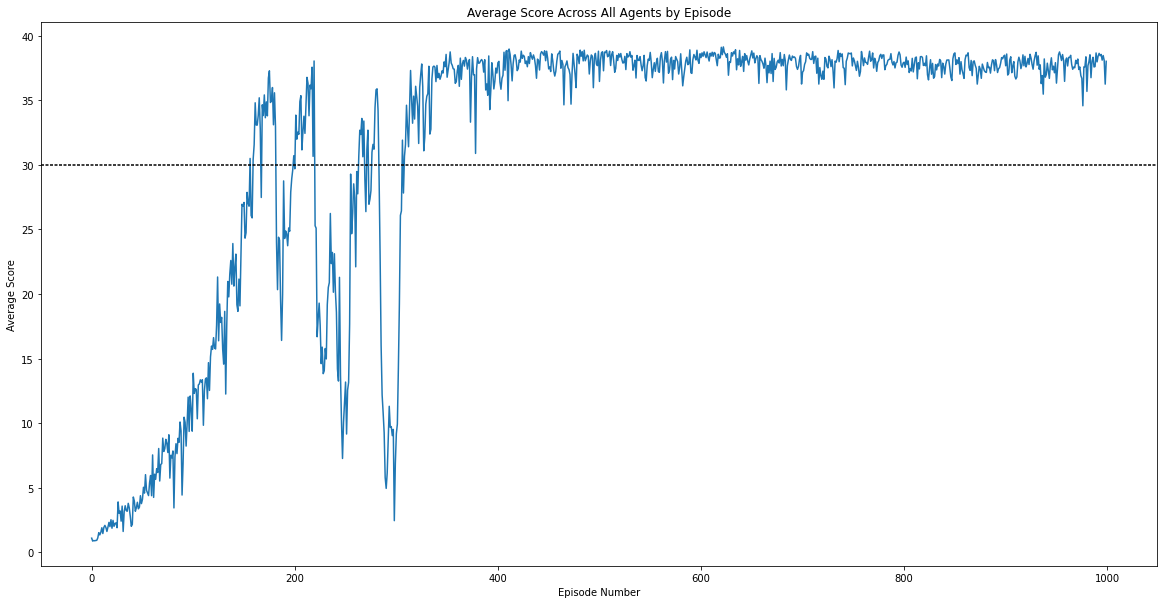

In [9]:
training_scores.plot(figsize=(20,10))
plt.title("Average Score Across All Agents by Episode")
plt.xlabel("Episode Number")
plt.ylabel("Average Score")
plt.axhline(y=30, color="black", dashes=(2,1))
plt.show()

In [3]:
print("The last episode in which the agent achieved an average score of <30 was episode",(training_scores[::-1] < 30).idxmax())

The last episode in which the agent achieved an average score of <30 was episode 307


As seen above, the agent initially improved quickly, but hit a period of instability between episodes ~150 and episode 307.  On episode 308 onward, however, it maintained a score of >30 and eventually it stabilized at a score of around 38.

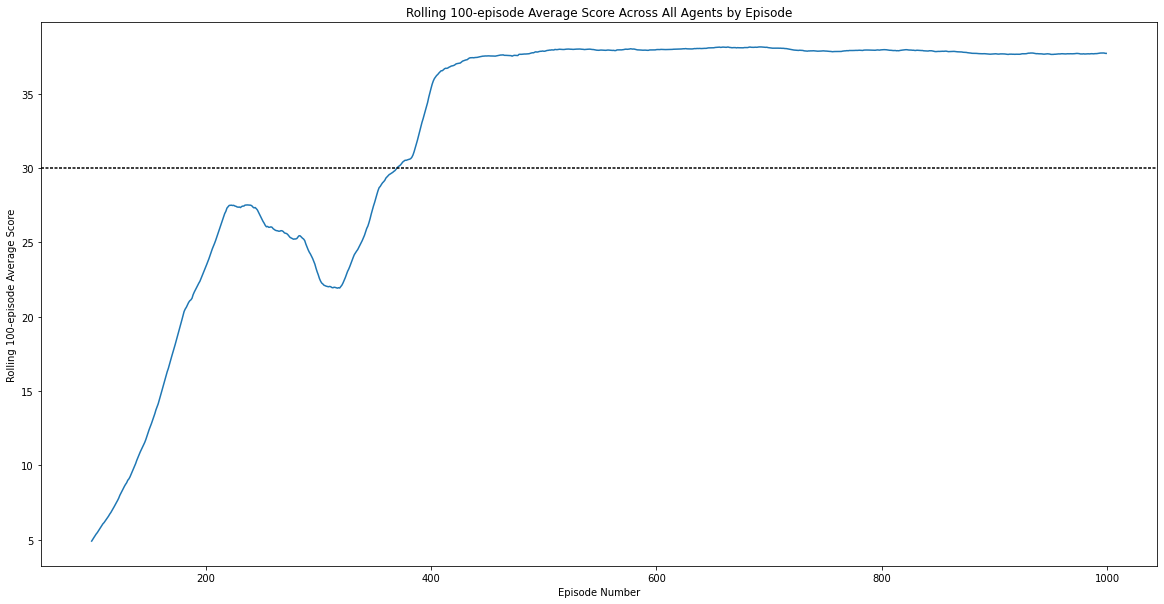

In [10]:
rolling_scores = training_scores.rolling(100).mean()
rolling_scores.plot(figsize=(20, 10))
plt.title("Rolling 100-episode Average Score Across All Agents by Episode")
plt.xlabel("Episode Number")
plt.ylabel("Rolling 100-episode Average Score")
plt.axhline(y=30, color="black", dashes=(2,1))
plt.show()

In [11]:
print("The agent first achieved a 100-episode rolling average score of >30 on episode",(rolling_scores > 30).idxmax())

The agent first achieved a 100-episode rolling average score of >30 on episode 370


With a little bit of pandas magic, we can see that the agent achieved a 100-episode rolling average score of >30 on episode 370, thus solving the environment.  Plotting the rolling 100-episode average rewards lets us confirm that after the agent achieved that score it never went back below the 30-point threshold, and it eventually achieved quite a stable score.

# Ideas for future Work

The next logical feature to implement for the agent would be Generalized Advantage Estimation.  This would allow for more fine-grained control of the value function calculated during n-step bootstrapping.  It would also be interesting to extend the implemenation to support multiple asynchronous agents and compare the performance of A3C to this A2C implementation.  There is also a lot of room to experiment with hyperparameters in the current implementation.  I did not experiment in-depth with the n used for n-step bootstrapping (I only tried n=1 and n=5).  Experimenting further with the learning rates, optimizers used, and network sizes for both the actor and critic could also yield interesting results.  Finally, it could be interesting to compare the current implementation's performance to that of an actor Actor-Critic which uses the Q-value directly as a baseline to stabilize the policy gradients; the current implementation uses the Advantage estimate, rather the Q-value estimate.